In [28]:
# prepares the notebook for "inline" graphing, and imports matplotlib library
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from os.path import isfile, join

In [29]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthesh, neghold etc)
def isIncreasing(L):
    return L[0] < L[len(L) - 1]
def isDecreasing(L):
    return L[0] > L[len(L) - 1]
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sortIntoSide(voltage, current):
    if isIncreasing(voltage) and isIncreasing(current):
        return "posThresh"
    elif isDecreasing(voltage) and isDecreasing(current):
        return "posHold"
    elif isDecreasing(voltage) and isIncreasing(current):
        return "negThresh"
    elif isIncreasing(voltage) and isDecreasing(current):
        return "negHold"
    else: 
        print("???")

In [30]:
# this will take a file name and device size and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.filePath = file_path
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_into_runs()

        # print(self.device_temp, self.device_number, self.file_name)
        # self.graph_all_data()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/")[1]

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'],sep='\t',skiprows=1)
        data = df5.values
        df5.head()
        
        self.number_of_data_points = len(data[:,0])
        print("number of data points: ", self.number_of_data_points)

        self.time = data[:,0]
        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]
        self.R = self.V / self.I

        print(self.V[:100], self.I[:100], self.R[:100])

        self.all_data = []

        for i in range(0, len(self.time)):
            self.all_data.append({
                'time': self.time[i],
                'I': self.I[i],
                'V': self.V[i],
                'temps': self.temps[i],
                'R': self.R[i]
            })

    def graph_all_data(self):
        print("All Data")
        plt.rcParams['figure.figsize'] = (5,3)
        plt.grid()
        # print("Temp: " , self.temp[0] , " - " , self.temp[len(self.temp) - 1] , " K")
        # plt.text(-1.5, 0.01, "Temp: " + str(self.temp[1]) + " - " + str(self.temp[len(self.temp) - 1]) + " K", fontsize=12)
        # plt.text(-0.5, 0.01, "Device: " + self.device_number, fontsize=12)
        # plt.text(0.5, 0.01, "Sample: " + self.sample_number, fontsize=12)
        plt.semilogy(self.V, self.I)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

    def graph_temp(self):
        print("Temp vs Time")
        plt.rcParams['figure.figsize'] = (5,3)
        plt.grid()
        plt.semilogy(self.temps, self.time)
        plt.xlabel('Time (s)')
        plt.ylabel('Temp (K)')
        plt.figure(np.random.randint(1000000000))

    def graph_r_vs_time(self):
        print("Resistance vs Time")
        plt.rcParams['figure.figsize'] = (5,3)
        plt.grid()
        plt.semilogy(self.R, self.time)
        plt.xlabel('Time (s)')
        plt.ylabel('Resistance (?)')
        plt.figure(np.random.randint(1000000000))

    def graph_runs_data(self, start, stop):
        print("runs: ", start, " - ", stop)
        plt.rcParams['figure.figsize'] = (5,3)
        plt.grid()
        # print("Temp: " , self.temp[0] , " - " , self.temp[len(self.temp) - 1] , " K")
        # plt.text(-1.5, 0.01, "Temp: " + str(self.temp[1]) + " - " + str(self.temp[len(self.temp) - 1]) + " K", fontsize=12)
        # plt.text(-0.5, 0.01, "Device: " + self.device_number, fontsize=12)
        # plt.text(0.5, 0.01, "Sample: " + self.sample_number, fontsize=12)
        plt.semilogy(self.V[start:stop], self.I[start:stop])
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

    def break_into_runs(self):
        self.max_v = np.amax(self.V)
        self.min_v = np.amin(self.V)
        self.all_zero_indexes = np.where(self.V == 0.0)

        self.V_in_runs = []
        self.all_data_in_runs = []
        for i in range(len(self.all_zero_indexes[0]) - 1):
            start = self.all_zero_indexes[0][i]
            stop = self.all_zero_indexes[0][i+1]
            self.V_in_runs.append(self.V[start:stop])

            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.V[start:stop])

            self.all_data_in_runs.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'temp': run_temp,
                'temp_std': run_temp_std,
            })

        self.number_of_runs = len(self.all_zero_indexes[0])
        print("number of runs: ", self.number_of_runs)

    def graph_one_run(self, run_to_graph):
        # plt.rcParams['figure.figsize'] = (0.001,0.001)
        plt.grid()
        # plt.text(-0.125, 0.01, "Temp: " + self.temp[1] + " - " + self.temp[len(self.temp) - 1] + " K", fontsize=12)
        # plt.text(0.25, 0.01, "Device: " + self.device_number, fontsize=12)
        # plt.text(0.65, 0.01, "Sample: " + self.sample_number, fontsize=12)
        # plt.text(0.5, 0.01, "Run: " + str(run_to_graph), fontsize=12)
        start = self.all_zero_indexes[0][run_to_graph]
        stop = self.all_zero_indexes[0][run_to_graph + 2]
        # print(self.V[start], self.I[stop])
        plt.semilogy(self.V[start:stop], self.I[start:stop])
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))
    
    def sort_runs_into_neg_pos(self):
        self.pos_runs = []
        self.neg_runs = []

        for run in self.all_data_in_runs:
            if (run['V'][2] > 0):
                self.pos_runs.append(run)
            else:
                self.neg_runs.append(run)
    
    def calculate_gradient_all_data(self):
        self.temp_gradient = []
        self.current_gradient = np.gradient(self.I)

        pos_current_runs_gradient = []
        neg_current_runs_gradient = []

        for run in self.pos_runs:  
            run_current = run['I']
            run_voltage = run['V']
            run_time = run['time']
            run_temps = run['temps']
            run_temp = run['temp']
            run_temp_std = run['temp_std']
            run_current_gradient = np.gradient(run_current)
            run_temps_gradient = np.gradient(run_temps)

            pos_current_runs_gradient.append({
                'time': run_time,
                'dI': run_current_gradient,
                'I': np.absolute(run_current),
                'V': run_voltage,
                'temps': run_temps,
                'dtemp': run_temps_gradient,
                'temp': run_temp,
                'temp_std': run_temp_std,
            })

        for run in self.neg_runs:  
            run_current = run['I']
            run_voltage = run['V']
            run_time = run['time']
            run_temps = run['temps']
            run_temp = run['temp']
            run_temp_std = run['temp_std']
            run_current_gradient = np.gradient(run_current)
            run_temps_gradient = np.gradient(run_temps)

            neg_current_runs_gradient.append({
                'time': run_time,
                'dI': run_current_gradient,
                'I': np.absolute(run_current),
                'V': run_voltage,
                'temps': run_temps,
                'dtemp': run_temps_gradient,
                'temp': run_temp,
                'temp_std': run_temp_std,
            })

        self.neg_current_runs_gradient = neg_current_runs_gradient
        self.pos_current_runs_gradient = pos_current_runs_gradient

    def find_max_gradient(self):
        for run in self.pos_current_runs_gradient: 
            largest_gradient_value = np.amax(run['dI'])
            max_gradient_index = np.where(run['dI'] == largest_gradient_value)

            # print("index: ", max_gradient_index)
        print(max_gradient_index[0][0])

    

number of data points:  595849
number of runs:  5958
All Data
Temp vs Time
Resistance vs Time


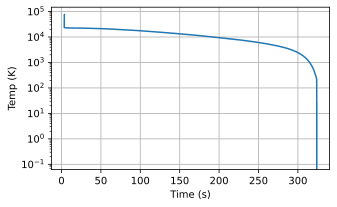

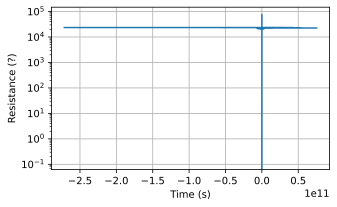

<Figure size 360x216 with 0 Axes>

In [31]:
# path_to_data = os.getcwd() + "/data/" # the folder where all the data is stored
# files = [] # stores all the files data as DataFile objects

# # go into the data folder and extract all file names
# for path in os.listdir(path_to_data):
#   if os.path.isfile(os.path.join(path_to_data, path)):
#       files.append(DataFile(path_to_data + path))

# print("total files: ", len(files))
# print()

# files_to_graph = []

# for file in files:
#   if(len(file.device_temp) == 3):
#     if(file.device_number == "D18"):
#       files_to_graph.append(file)

# files_to_graph.sort(key=lambda x: x.device_temp)

# good_files = []
# for file in files_to_graph:
#   print(file.index)
#   good_files.append(file)

# for file in good_files:
#   file.graph_all_data()

  # print(file.index)

# 180k sam3 d18
# 220k sam3 d18

# for x in range(12,14): 

# print(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042023_D18_try2.txt")

theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042023_D18_try2.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042723_D18.txt");
# theFile.break_into_runs()
# theFile.sort_runs_into_neg_pos()
# print("Filename: ", theFile.file_name)
theFile.graph_all_data()
theFile.graph_temp()
theFile.graph_r_vs_time()
# theFile.graph_runs_data(0,1000)
# theFile.graph_runs_data(2000,3000, 1)
# theFile.graph_runs_data(4000,5000, 2)

# for x in range(10):
#   number_of_runs = theFile.number_of_runs
#   i = (int)((number_of_runs / 12) * x)
#   print("temp: ", theFile.all_data_in_runs[x]['temp'], " std: ", theFile.all_data_in_runs[x]['temp_std'])
#   # print(theFile.all_data_in_runs[x])
#   theFile.graph_one_run(i)
  


# theFile.graph_one_run(100)
# theFile.graph_one_run(200)
# theFile.graph_one_run(300)
# theFile.graph_one_run(400)
# theFile.graph_one_run(500)
# theFile.graph_one_run(600)
# # print(theFile.pos_runs[3])
# theFile.calculate_gradient_all_data()
# theFile.find_max_gradient()

In [32]:
# todo

# graph resistance vs temp
# temp vs current at 0.25 

# hold vs temp
# thresh vs temp